In [ ]:
# import libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score

# import five models for training
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# import the matrics
from sklearn.metrics import mean_squared_error,root_mean_squared_error,r2_score


In [100]:
# import the clean data
df = pd.read_csv("../Data/process.csv")
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,9100000,6000,4,1,2,yes,no,yes,no,no,2,no,semi-furnished
1,9100000,6600,4,2,2,yes,yes,yes,no,yes,1,yes,unfurnished
2,8960000,8500,3,2,4,yes,no,no,no,yes,2,no,furnished
3,8890000,4600,3,2,2,yes,yes,no,no,yes,2,no,furnished
4,8855000,6420,3,2,2,yes,no,no,no,yes,1,yes,semi-furnished


## Feature Engineering

In [101]:
df['price_per_unit_area'] = (df['price'] / df['area']).round(3)
df['bathroom_per_bedrooms'] = (df['bathrooms'] / df['bedrooms']).round(3)

In [ ]:
df["airconditioning"]=df["airconditioning"].map({'yes':1,'no':0})
df["guestroom"]=df["guestroom"].map({"yes":1,"no":0})

df["hotwaterheating"]=df["hotwaterheating"].map({"yes":1,"no":0})
df["basement"]=df["basement"].map({"yes":1,"no":0})

df["prefarea"]=df["prefarea"].map({"yes":1,"no":0})
df["mainroad"]=df["mainroad"].map({"yes":1,"no":0})

In [103]:
#  Creating luxury index
df['luxury_index'] = ((df['airconditioning'] + df['hotwaterheating'] + df['guestroom']) / 3 ).round(3) # Average score
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price_per_unit_area,bathroom_per_bedrooms,luxury_index
0,9100000,6000,4,1,2,1,0,1,0,0,2,0,semi-furnished,1516.667,0.250,0.000
1,9100000,6600,4,2,2,1,1,1,0,1,1,1,unfurnished,1378.788,0.500,0.667
2,8960000,8500,3,2,4,1,0,0,0,1,2,0,furnished,1054.118,0.667,0.333
3,8890000,4600,3,2,2,1,1,0,0,1,2,0,furnished,1932.609,0.667,0.667
4,8855000,6420,3,2,2,1,0,0,0,1,1,1,semi-furnished,1379.283,0.667,0.333


 ### Encoding the categorical feature

In [104]:
orEnd = OrdinalEncoder()
df["furnishingstatus"] = orEnd.fit_transform(df[["furnishingstatus"]])
df.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price_per_unit_area,bathroom_per_bedrooms,luxury_index
0,9100000,6000,4,1,2,1,0,1,0,0,2,0,1.0,1516.667,0.250,0.000
1,9100000,6600,4,2,2,1,1,1,0,1,1,1,2.0,1378.788,0.500,0.667
2,8960000,8500,3,2,4,1,0,0,0,1,2,0,0.0,1054.118,0.667,0.333


### Scaling the numerical feature

In [105]:
# using standardScaler for scaling

col_to_scale = ['area', 'bedrooms', 'bathrooms', 'stories', 'price_per_unit_area','price']
scaler = StandardScaler()

# Scale the selected columns
df[col_to_scale] = scaler.fit_transform(df[col_to_scale])

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price_per_unit_area,bathroom_per_bedrooms,luxury_index
0,2.822404,0.473486,1.446537,-0.561951,0.243845,1,0,1,0,0,2,0,1.0,1.599446,0.250,0.000
1,2.822404,0.769908,1.446537,1.592196,0.243845,1,1,1,0,1,1,1,2.0,1.186740,0.500,0.667
2,2.734632,1.708577,0.077632,1.592196,2.568059,1,0,0,0,1,2,0,0.0,0.214921,0.667,0.333
3,2.690746,-0.218165,0.077632,1.592196,0.243845,1,1,0,0,1,2,0,0.0,2.844465,0.667,0.667
4,2.668803,0.680981,0.077632,1.592196,0.243845,1,0,0,0,1,1,1,1.0,1.188221,0.667,0.333


In [106]:
X = df.drop("price" ,axis=1)
y = df["price"]

In [107]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### Building model 

In [108]:
# Define the first model
lin_model = LinearRegression()

# Define a grid of hyperparameters to tune
param_grid = {
    'fit_intercept': [True, False],   
}

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=lin_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and corresponding model
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute and display performance metrics
mse = mean_squared_error(y_test, y_pred)
# using the root mean error
rmse = np.sqrt(mse)
# using the r2 score
score = r2_score( y_pred,y_test)

# print the results
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"r2_score:{score}")

Best parameters: {'fit_intercept': True}
Mean Squared Error: 0.17189474561628115
Root Mean Squared Error: 0.4146019122197595
r2_score:0.8213876513519911


In [109]:
# Difine the second model
rid_model = Ridge()

# Hyperparameter tuning: Grid search for the best alpha (regularization parameter)
param_grid = {'alpha': [0.1, 1.0, 0.01,0.001,10.0, 100.0]}  
grid_search = GridSearchCV(estimator=rid_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=7)
grid_search.fit(X_train, y_train)

# Best parameter and corresponding model
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Evaluate the tuned model
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)
y_pred = ridge_best.predict(X_test)

# Compute and display performance metrics
mse = root_mean_squared_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
rmse=np.sqrt(mse)
# apply the r2 score 
r2 = r2_score(y_pred,y_test)

print(f"Mean Squared Error: {mse}")
print(f"root mean squared error:{rmse}")
print(f"r2_score :{r2}")

Best alpha: 1.0
Mean Squared Error: 0.41566541154617004
root mean squared error:0.6447211890004625
r2_score :0.8190794507842092


In [110]:
# Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],     # Depth of trees
    'min_samples_split': [2, 5, 10], # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]    # Minimum samples required at a leaf node
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

# Compute and display performance metrics
mse = mean_squared_error(y_test, y_pred)

# root mean square error
rmse = np.sqrt(mse)

# r2 score 
r2_value= r2_score(y_pred,y_test)

# print the results
print(f"Mean Squared Error: {mse}")
print(f"root_mean_squared_error:{rmse}")
print(f"r2 score :{r2_value}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 0.04766980587768453
root_mean_squared_error:0.21833416104147452
r2 score :0.9549406332512704


In [113]:
# Define the XGBRegressor model
xgb = XGBRegressor(random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [30, 45, 90, 150, 170],  
    'max_depth': [None, 15, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}


# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model
xgb_best =  XGBRegressor(**best_params, random_state=42)
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)

# Compute and display performance metrics
mse = mean_squared_error(y_test, y_pred)

# root mean square error
rmse = np.sqrt(mse)

# r2 score 
r2_value= r2_score(y_pred,y_test)

# print the results
print(f"Mean Squared Error: {mse}")
print(f"root_mean_squared_error:{rmse}")
print(f"r2 score :{r2_value}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 170, 'subsample': 0.6}
Mean Squared Error: 0.028073033296414293
root_mean_squared_error:0.1675500919021362
r2 score :0.9761068848418465


In [114]:
feature_importances = xgb_best.feature_importances_
print(feature_importances)


[0.244335   0.00442535 0.1099887  0.0090602  0.00749215 0.00682623
 0.01170509 0.02372839 0.02917454 0.04392348 0.08659748 0.01193314
 0.27713168 0.01153747 0.12214107]


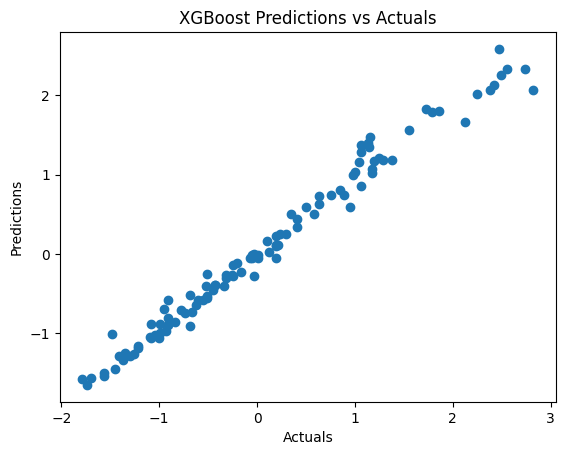

In [115]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("Actuals")
plt.ylabel("Predictions")
plt.title("XGBoost Predictions vs Actuals")
plt.show()
